In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import base64
from io import BytesIO
import numpy as np
from src import model, preprocessor, pose_mask_generation
import requests as r
from dotenv import load_dotenv
import pathlib
load_dotenv(dotenv_path=pathlib.Path('../../dev.env'))

True

In [2]:
print("Loading model")
diffusion_model = model.Model("C:/Users/kevmo/Documents/ai_prototyping/auth.json")

Loading model


Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 7493.40it/s]


In [11]:
# Give me a ...
prompt = "a person wearing a pair of pink pants"
path_prefix = "C:/Users/kevmo/Documents/ai_prototyping/text2img"
IMAGE_PATH = f'{path_prefix}/sample_images/side_poser.png'
#IMAGE_PATH = f'{path_prefix}/sample_images/brandon-atchison-eexdeq3NleQ-unsplash.jpg'
#IMAGE_PATH = f'{path_prefix}/sample_images/christian-buehner-vbdil5l6AZE-unsplash.jpg'
#IMAGE_PATH = f'{path_prefix}/sample_images/stephanie-liverani-Zz5LQe-VSMY-unsplash.jpg'
#IMAGE_PATH = f'{path_prefix}/sample_images/elijah-m-henderson-jRA-yoDL68M-unsplash.jpg'
#IMAGE_PATH = f'{path_prefix}/sample_images/cliff_woman.jpg'
IMAGE_PATH = f'{path_prefix}/sample_images/standing_woman.jpg'
#IMAGE_PATH = "C:/Users/kevmo/Downloads/sonnie-hiles-gG70fyu3qsg-unsplash.jpg"
#IMAGE_PATH = "inpainted_sample.png"

Run the main algorithm routines

load image + preprocess


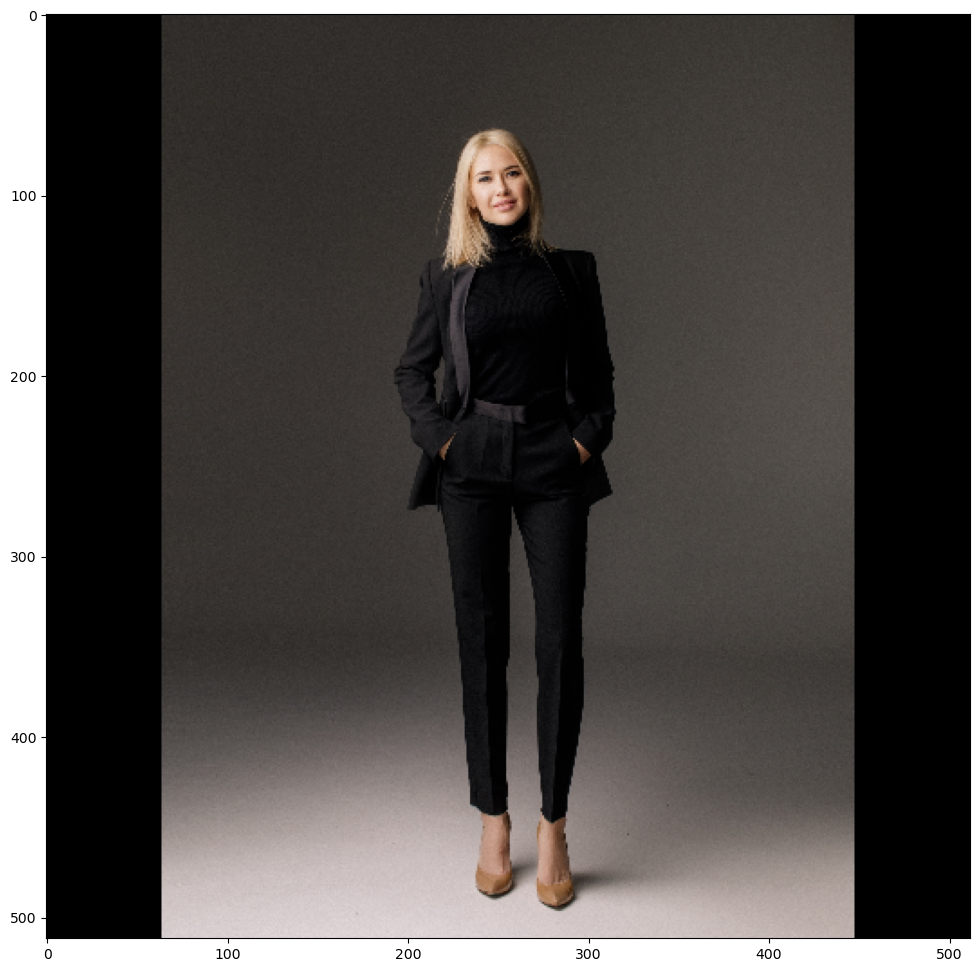

generating pose mask
Blob type identified: bottom_half


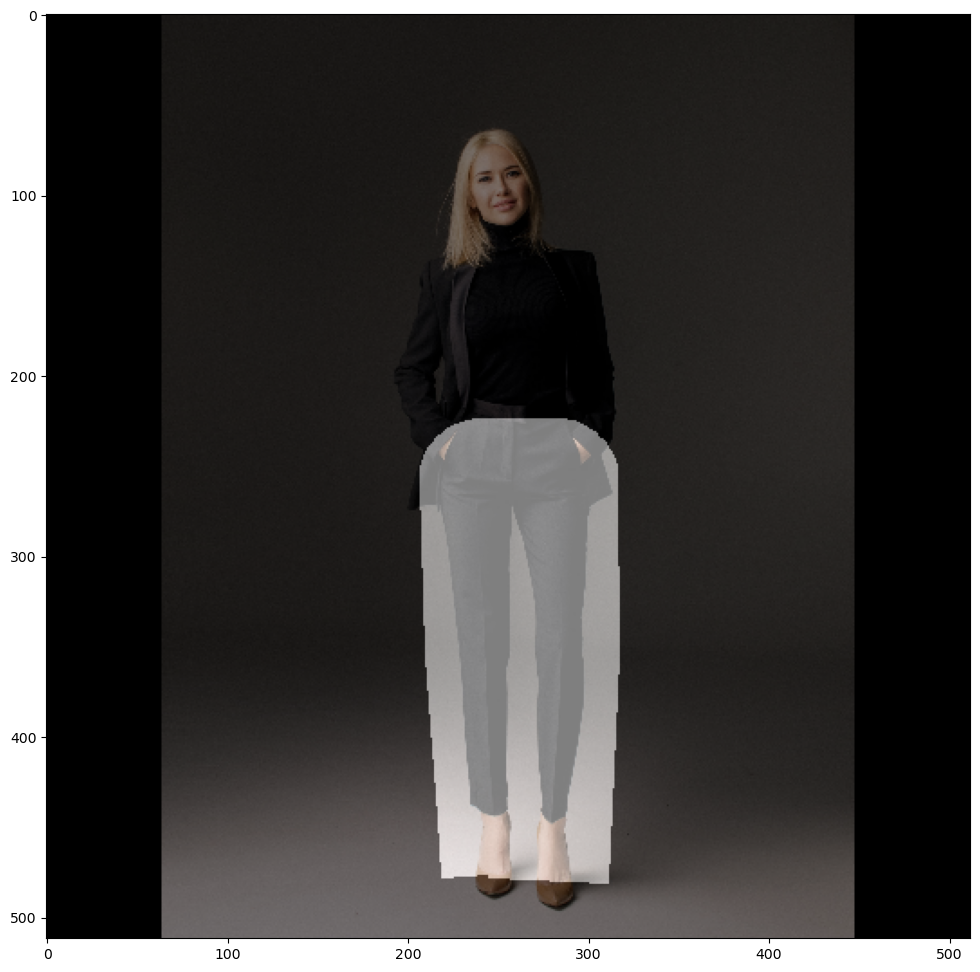

In [7]:
print("load image + preprocess")
primary_image_arr = preprocessor.process_input(image_path=IMAGE_PATH)
primary_image_arr = preprocessor.preprocessing(primary_image_arr)
plt.figure(figsize=(20,12))
plt.imshow(primary_image_arr)
plt.show()

print("generating pose mask")
mask_image_arr, blob_type = pose_mask_generation.translate_prompt_to_body_blob(primary_image_arr, prompt)
print("Blob type identified:", blob_type)
plt.figure(figsize=(20,12))
plt.imshow(primary_image_arr)
plt.imshow(mask_image_arr, cmap='jet', alpha=0.5)
plt.show()

# alpha channel processing for openAI DALLE model
# base_input_image = Image.fromarray(cv2.cvtColor(primary_image_arr, cv2.COLOR_RGB2RGBA))

# mask_rgba_arr = cv2.cvtColor(mask_image_arr, cv2.COLOR_RGB2RGBA)
# mask_rgba_arr[:,:,-1] = mask_rgba_arr[:,:,0]
# mask_rgba_arr[:,:,-1] = abs(mask_rgba_arr[:,:,-1] - 255)
# print(mask_rgba_arr.shape, mask_rgba_arr.max(),mask_rgba_arr.min())
# mask_input_image = Image.fromarray(mask_rgba_arr.astype(np.uint8))
# plt.imshow(mask_rgba_arr[:,:,-1])
# plt.show()

base_input_image = Image.fromarray(primary_image_arr)
mask_input_image = Image.fromarray(mask_image_arr)


base_buffered = BytesIO()
mask_buffered = BytesIO()

base_input_image.save(base_buffered, format="PNG")
mask_input_image.save(mask_buffered, format="PNG")

200
post-processing
save result to disk


Text(0.5, 1.0, 'Give me a person wearing a pair of pink pants')

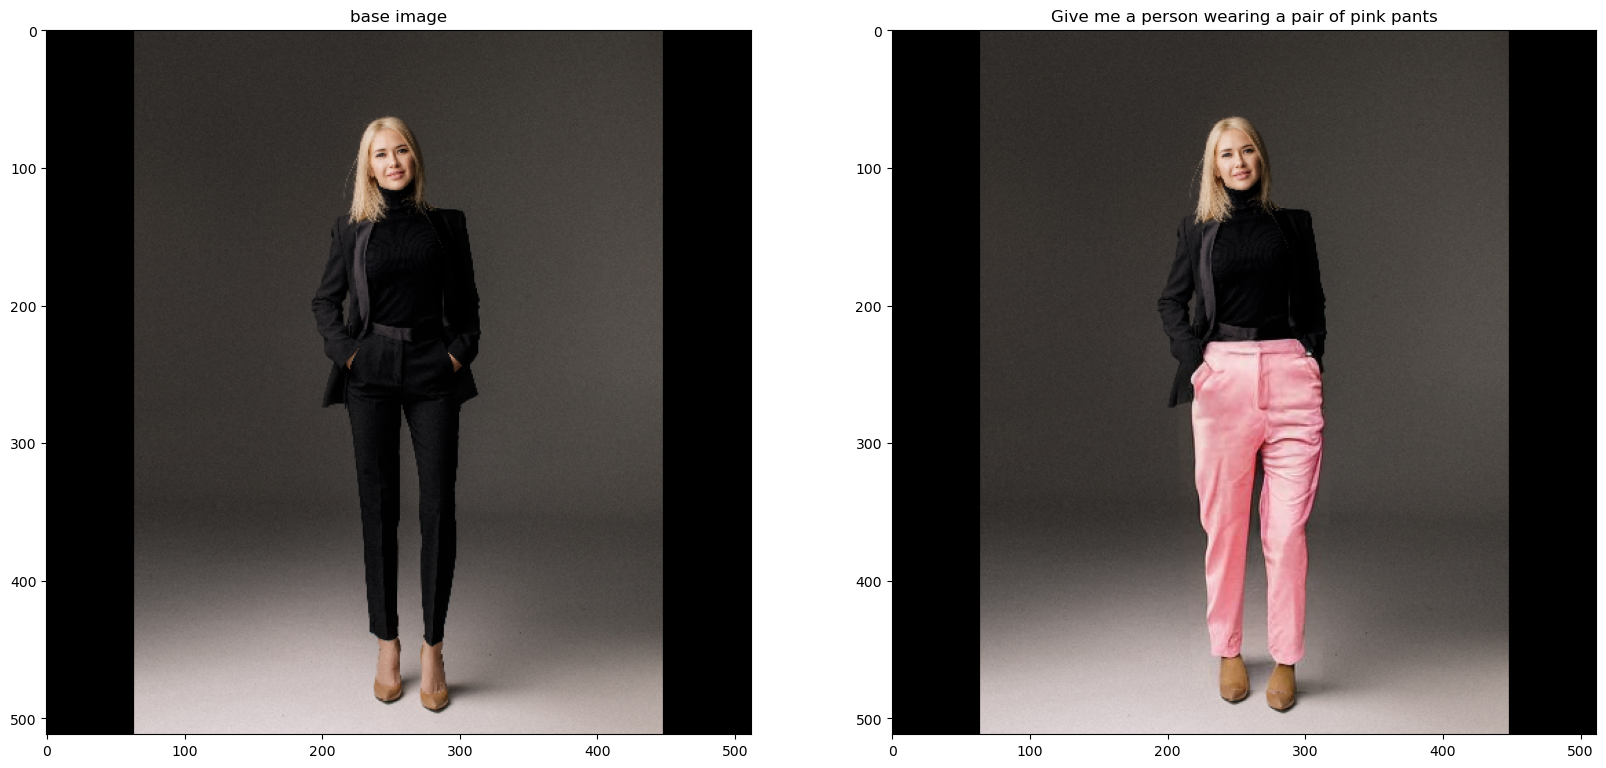

In [17]:
local = False
if local:
        print("generate inpainting result")
        output_image: Image = diffusion_model.infer(prompt=prompt, base_image=base_input_image, mask_image=mask_input_image)
else:
        # live usage
        # prepare sample payload
        base_buffered = BytesIO()
        mask_buffered = BytesIO()
        Image.fromarray(primary_image_arr).save(base_buffered, format="JPEG")
        Image.fromarray(mask_image_arr).save(mask_buffered, format="JPEG")
        base_image_str = base64.b64encode(base_buffered.getvalue()).decode()
        mask_image_str = base64.b64encode(mask_buffered.getvalue()).decode()

        payload = {"inputs": prompt, "image": base_image_str, "mask_image": mask_image_str}
        authorization = 'Bearer ' + os.getenv("HF_TOKEN")
        # headers
        headers = {
                "Authorization": authorization,
                "Content-Type": "application/json",
                "Accept": "image/png" # important to get an image back
        }

        response = r.post(os.getenv("HF_ENDPOINT_URL"), headers=headers, json=payload)
        print(response.status_code)
        output_image: Image = Image.open(BytesIO(response.content))


print("post-processing")
output_image = preprocessor.restore_mask(
        output_image,
        np.asarray(base_input_image),
        np.asarray(mask_input_image)
)

print("save result to disk")
output_image.save("./inpainted_sample.png")
mask_input_image.save("./inpainted_sample_mask.png")

fig, ax = plt.subplots(1,2, figsize=(20,12))
ax[0].imshow(primary_image_arr)
ax[0].set_title("base image")
ax[1].imshow(output_image)
ax[1].set_title("Give me " + prompt)


In [19]:
print(response.__dict__.keys())

dict_keys(['_content', '_content_consumed', '_next', 'status_code', 'headers', 'raw', 'url', 'encoding', 'history', 'reason', 'cookies', 'elapsed', 'request', 'connection'])


In [ ]:
processed_output_img = np.asarray(output_image) * (np.asarray(mask_input_image) / 255) + np.asarray(base_input_image) * (1 - np.asarray(mask_input_image) / 255)



In [ ]:
#plt.imshow(output_image)
plt.imshow(Image.fromarray(processed_output_img.astype(np.uint8)))

In [ ]:
(np.asarray(output_image) * (np.asarray(mask_input_image) / 255)).max()

In [ ]:
(np.asarray(mask_input_image) / 255).max()

In [4]:

import os

import openai
import base64
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


True

In [5]:

# openai.organization = "YOUR_ORG_ID"
openai.api_key = os.getenv("MODEL_API_KEY")

In [6]:
#openai.Model.list()

In [7]:
def decode_image(response):
    output_image = Image.open(BytesIO(base64.b64decode(response['data'][0]["b64_json"])))
    output_arr = np.asarray(output_image)
    plt.figure(figsize=(20,12))
    plt.imshow(output_arr)
    plt.show()

### Image generation

In [30]:
response = openai.Image.create(
  prompt="a red porsche sports car",
  n=1,
  size="1024x1024",
  response_format="b64_json"
)


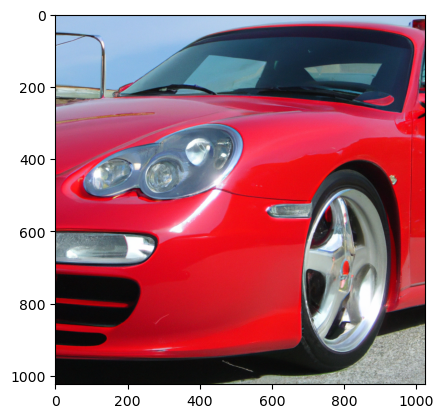

In [33]:
decode_image(response)

## Inpainting

In [24]:
response = openai.Image.create_edit(
  image=base_buffered.getvalue(),
  mask=mask_buffered.getvalue(),
  prompt="a woman wearing blue pants",
  n=1,
  size="1024x1024",
  response_format="b64_json"
)

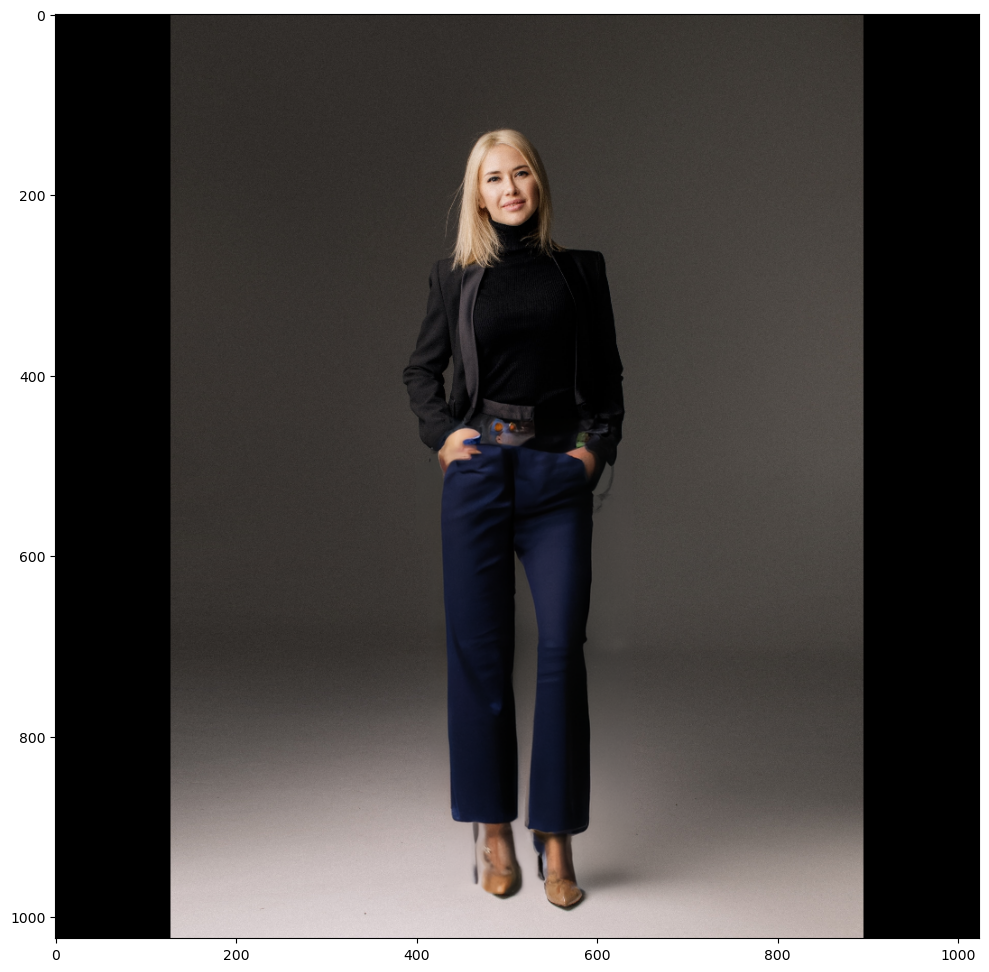

In [25]:
decode_image(response)

In [47]:
red, green, blue, alpha = mask_input_image.split()


In [48]:
alpha.show()